In [1]:
#importing necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load the MoveNet model from TensorFlow Hub
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [10]:
# Function to draw keypoints on an image
def draw_keypoints(image, keypoints, confidence_threshold):
    """
    Draw keypoints on an image.

    Args:
        image (numpy.ndarray): The input image.
        keypoints (numpy.ndarray): Detected keypoints with confidence scores.
        confidence_threshold (float): The confidence threshold for drawing keypoints.

    Returns:
        None
    """

    # Extract the dimensions of the input image
    y, x, c = image.shape

    # Reshape and normalize keypoints to match the image dimensions
    # and account for the confidence scores
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    # Iterate through the keypoints and draw those with confidence above the threshold
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            # Draw keypoints on the image as lime-colored circles
            plt.scatter(kx, ky, color='lime', s=50, marker='o')

In [4]:
# Define edges between keypoints for drawing connections
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [11]:
# Function to draw connections between keypoints
def draw_connections(image, keypoints, edges, confidence_threshold):
    """
    Draw connections between keypoints on an image.

    Args:
        image (numpy.ndarray): The input image.
        keypoints_with_scores (numpy.ndarray): Detected keypoints with confidence scores.
        edges (dict): Dictionary defining connections between keypoints.
        confidence_threshold (float): The confidence threshold for drawing connections.

    Returns:
        None
    """
    
    y, x, c = image.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    # Loop through edges in the EDGES dictionary and draw connections between keypoints
    for edge, _ in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        # Check if both keypoints have confidence scores above the threshold
        if (c1 > confidence_threshold) and (c2 > confidence_threshold):
            # Draw a connection line between the keypoints
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

In [12]:
# Function to process and analyze the keypoints of people in an image
def loop_through_people(image, keypoints_with_scores, edges, confidence_threshold):
    """
    Loop through people in the image and draw keypoints and connections.

    Args:
        image (numpy.ndarray): The input image.
        keypoints_with_scores (numpy.ndarray): Detected keypoints with confidence scores.
        edges (dict): Dictionary defining connections between keypoints.
        confidence_threshold (float): The confidence threshold for drawing keypoints and connections.

    Returns:
        None
    """
    
    for person in keypoints_with_scores:
        draw_connections(image, person, edges, confidence_threshold)
        draw_keypoints(image, person, confidence_threshold)

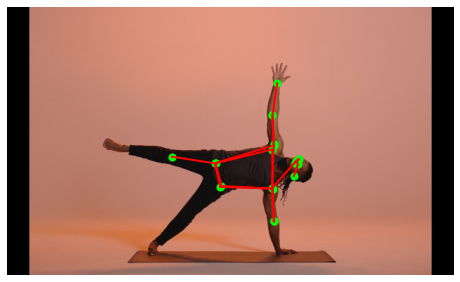

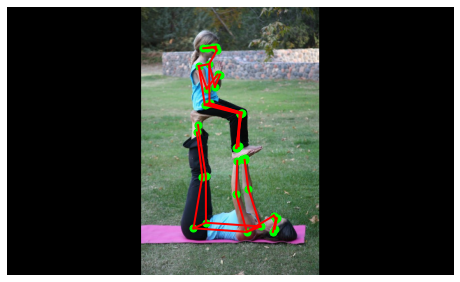

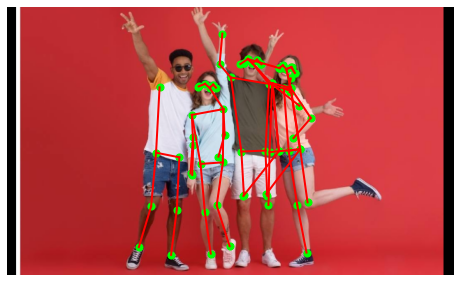

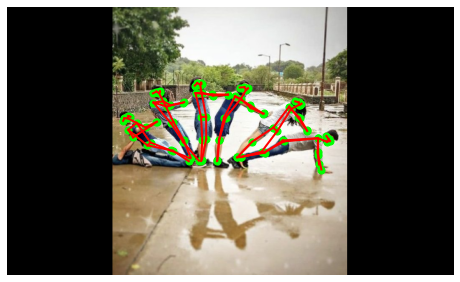

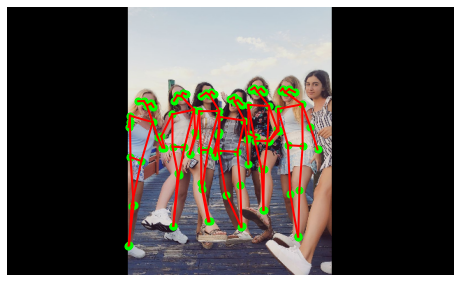

In [26]:
# Path to the directory containing the test images
image_dir = r"C:\Users\HP\Desktop\Pose estimation\test images"

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Loop through each image and perform pose estimation
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Load and preprocess the image
    img = plt.imread(image_path)
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384, 640)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Perform detection
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))
    
    # Normalize the image data to [0, 1] range
    normalized_img = img[0] / 255.0
    
    # Clip pixel values to [0, 1] range
    normalized_img = np.clip(normalized_img, 0, 1)
    
    # Plot keypoints and connections
    plt.figure(figsize=(8, 8))
    plt.imshow(normalized_img)
    
    loop_through_people(normalized_img, keypoints_with_scores, EDGES, 0.1)
    
    plt.axis('off')
    plt.show()